In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


In [3]:
df = pd.read_csv(r'C:\data\forestfires.csv')
print(f"Shape: {df.shape}\n")
df.head()

Shape: (55367, 43)



,Unnamed: 0.1,Unnamed: 0,fire_name,fire_size,fire_size_class,stat_cause_descr,latitude,longitude,state,disc_clean_date,...,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness
0,0,0,NaN,10.0,C,Missing/Undefined,18.105072,-66.753044,PR,11/2/2007,...,3.250413,78.216590,76.793750,76.381579,78.724370,0.0,0.0,0.0,0.0,0.017923
1,1,1,NaN,3.0,B,Arson,35.038330,-87.610000,TN,11/12/2006,...,2.122320,70.840000,65.858911,55.505882,81.682678,59.8,8.4,0.0,86.8,0.184355
2,2,2,NaN,60.0,C,Arson,34.947800,-88.722500,MS,2/29/2004,...,3.369050,75.531629,75.868613,76.812834,65.063800,168.8,42.2,18.1,124.5,0.194544
3,3,3,WNA 1,1.0,B,Debris Burning,39.641400,-119.308300,NV,6/6/2005,...,0.000000,44.778429,37.140811,35.353846,0.000000,10.4,7.2,0.0,0.0,0.487447
4,4,4,NaN,2.0,B,Miscellaneous,30.700600,-90.591400,LA,9/22/1999,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.214633


__Drop Columns__

In [4]:
cols_to_drop = [
    'Unnamed: 0.1', 'Unnamed: 0', 'fire_name',
    'cont_clean_date', 'disc_date_final', 'cont_date_final',
    'putout_time', 'disc_clean_date', 'disc_date_pre',
    'wstation_wban', 'wstation_byear', 'wstation_eyear',
    'fire_size','Temp_pre_30', 'Temp_pre_15', 'Temp_cont',
    'Wind_pre_30', 'Wind_pre_15', 'Wind_cont',
    'Hum_pre_30', 'Hum_pre_15', 'Hum_cont',
    'Prec_pre_30', 'Prec_pre_15', 'Prec_cont',
    'weather_file','discovery_month'    
]

Reasons for dropping
#### 1. `Unnamed: 0`, `Unnamed: 0.1`
- These are auto‑generated index columns created when saving/loading the CSV.
- They act purely as row IDs and have no relationship to fire behavior or size.
- Keeping them would only add noise and unnecessary dimensionality.

---

#### 2. `fire_name`
- Human‑readable fire incident name, often arbitrary and inconsistent.
- Not available in a standardized form for future fires at prediction time.

---

#### 3. `fire_size`  (when predicting `fire_size_class`)
- This is a continuous version of the same target concept.
- Using it as a feature when predicting `fire_size_class` would leak direct information about the label.
- To avoid target leakage, only the class label is kept as the target; `fire_size` is dropped.

---

#### 4. Date/time cleanup columns  
Examples: `disc_clean_date`, `cont_clean_date`, `disc_date_final`, `cont_date_final`, `disc_date_pre`, `discovery_month`
- These are intermediate or cleaned date fields used during preprocessing.
- Some contain information only known after the event progresses (e.g., containment date), which would not be available at prediction time.
- To avoid leakage and redundant representations of the same temporal info, only chosen time features are kept and these date columns are dropped.

---

#### 5. Weather station metadata  
Examples: `wstation_wban`, `wstation_byear`, `wstation_eyear`, `weather_file`
- `wstation_wban` is an alternative station identifier; `wstation_usaf` is retained and encoded instead, so the second ID is redundant.
- `wstation_byear` / `wstation_eyear` describe the station’s operational period, not the specific fire event.
- `weather_file` is a technical reference to the source file, not intrinsic to fire behavior.
- These fields are more about data management than predictive signal, so they are removed.

---

#### 6.Redundant weather features  
- Temperature: `Temp_pre_30`, `Temp_pre_15`, `Temp_pre_7`, `Temp_cont`  
- Wind: `Wind_pre_30`, `Wind_pre_15`, `Wind_pre_7`, `Wind_cont`  
- Humidity: `Hum_pre_30`, `Hum_pre_15`, `Hum_pre_7`, `Hum_cont`  
- Precipitation: `Prec_pre_30`, `Prec_pre_15`, `Prec_pre_7`, `Prec_cont`

**Why most are dropped:**
- These sets are highly correlated: 30‑day, 15‑day, and 7‑day pre‑fire aggregates of the same variable convey similar information.
- Keeping all horizons inflates feature count and can make models more complex without proportional performance gain.
- A a single, more interpretable horizon (`*_pre_7` for each variable) is kept as the main weather signal and drops the longer‑horizon and “cont” (containment‑time) versions to reduce redundancy and potential leakage.

---

#### 7. `discovery_month` (string/categorical duplicate of month)
- The cleaned / engineered month field (`disc_pre_month`) is already used and properly encoded.
- `discovery_month` is a redundant representation of the same information and may be less clean.
- To avoid duplicate encodings of essentially the same feature, the older/less standard column is dropped.

In [5]:
df.drop(columns=cols_to_drop, inplace=True)
print("Columns after dropping:", df.columns.tolist())

Columns after dropping: ['fire_size_class', 'stat_cause_descr', 'latitude', 'longitude', 'state', 'disc_pre_year', 'disc_pre_month', 'wstation_usaf', 'dstation_m', 'Vegetation', 'fire_mag', 'Temp_pre_7', 'Wind_pre_7', 'Hum_pre_7', 'Prec_pre_7', 'remoteness']


__Remove Duplicates__

In [6]:
df.drop_duplicates(inplace=True)
print(f"Data shape after removing duplicates: {df.shape}")

Data shape after removing duplicates: (55312, 16)


__Missing Values__

In [7]:
missing = df.isnull().sum().sort_values(ascending=False)
print("Missing values:\n", missing)

Missing values:
 fire_size_class     0
stat_cause_descr    0
latitude            0
longitude           0
state               0
disc_pre_year       0
disc_pre_month      0
wstation_usaf       0
dstation_m          0
Vegetation          0
fire_mag            0
Temp_pre_7          0
Wind_pre_7          0
Hum_pre_7           0
Prec_pre_7          0
remoteness          0
dtype: int64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55312 entries, 0 to 55366
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fire_size_class   55312 non-null  object 
 1   stat_cause_descr  55312 non-null  object 
 2   latitude          55312 non-null  float64
 3   longitude         55312 non-null  float64
 4   state             55312 non-null  object 
 5   disc_pre_year     55312 non-null  int64  
 6   disc_pre_month    55312 non-null  object 
 7   wstation_usaf     55312 non-null  object 
 8   dstation_m        55312 non-null  float64
 9   Vegetation        55312 non-null  object 
 10  fire_mag          55312 non-null  float64
 11  Temp_pre_7        55312 non-null  float64
 12  Wind_pre_7        55312 non-null  float64
 13  Hum_pre_7         55312 non-null  float64
 14  Prec_pre_7        55312 non-null  float64
 15  remoteness        55312 non-null  float64
dtypes: float64(9), int64(1), object(6)
memory usa

In [9]:
for col in df.columns:
    print(f"\n--- {col} ---")
    print(f"Number of unique values: {df[col].nunique()}")
    print("Top unique values (with counts):\n", df[col].value_counts(dropna=False).head(20))


--- fire_size_class ---
Number of unique values: 6
Top unique values (with counts):
 fire_size_class
B    36479
C    10802
G     3969
F     1968
D     1394
E      700
Name: count, dtype: int64

--- stat_cause_descr ---
Number of unique values: 13
Top unique values (with counts):
 stat_cause_descr
Debris Burning       14270
Arson                 9710
Miscellaneous         8340
Lightning             8215
Missing/Undefined     5042
Equipment Use         4105
Campfire              1366
Children              1278
Smoking               1181
Railroad              1021
Powerline              483
Fireworks              223
Structure               78
Name: count, dtype: int64

--- latitude ---
Number of unique values: 46329
Top unique values (with counts):
 latitude
17.993565    19
47.866600    19
33.950000    16
34.700000    14
17.970539    13
33.350100    13
18.036682    13
47.883300    13
35.350000    13
34.966700    13
33.351700    12
34.400000    12
17.976648    12
33.750000    12
34.03330

__Identify columns__

In [10]:
target_col = 'fire_size_class'
cat_cols = ['stat_cause_descr', 'state', 'disc_pre_month', 'Vegetation','wstation_usaf']
num_cols_all = [
    'latitude', 'longitude', 'disc_pre_year', 'dstation_m',
    'fire_mag', 'Temp_pre_7', 'Wind_pre_7', 'Hum_pre_7',
    'Prec_pre_7', 'remoteness'
]

num_cols_for_outliers = [
    'disc_pre_year', 'dstation_m', 'fire_mag',
    'Temp_pre_7', 'Wind_pre_7', 'Hum_pre_7',
    'Prec_pre_7', 'remoteness'
]
freq_cols = ["state", "stat_cause_descr","wstation_usaf" ]
ord_cols = ["disc_pre_month", "Vegetation"]

__Outliers__

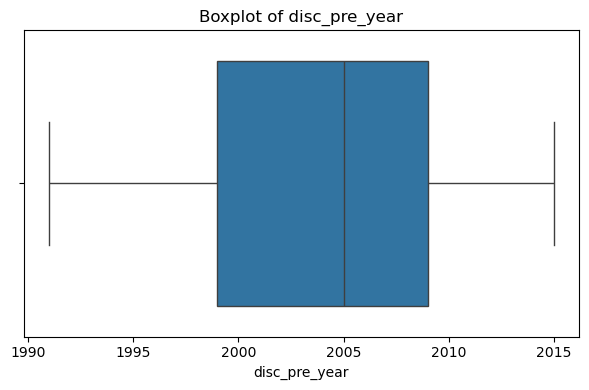

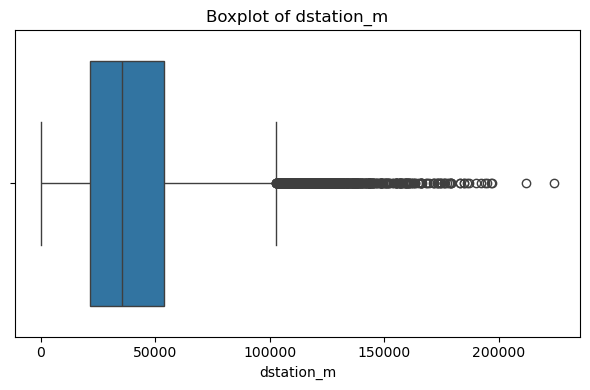

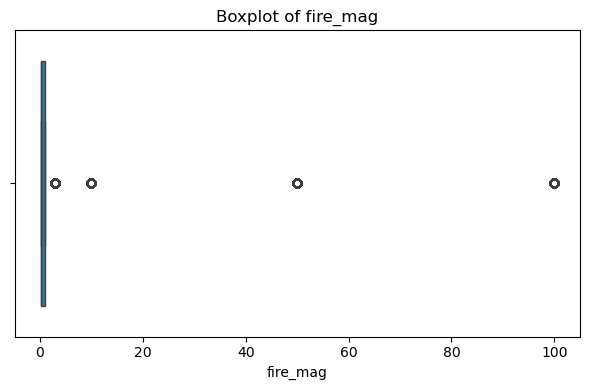

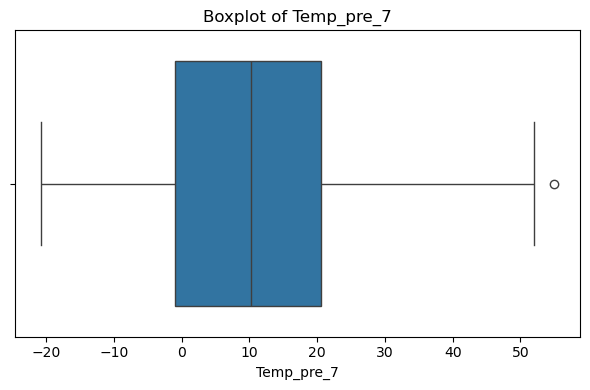

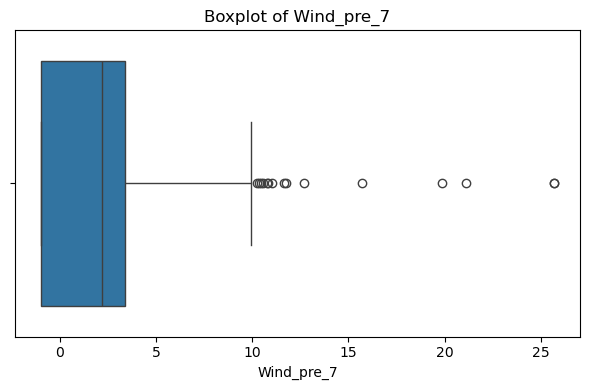

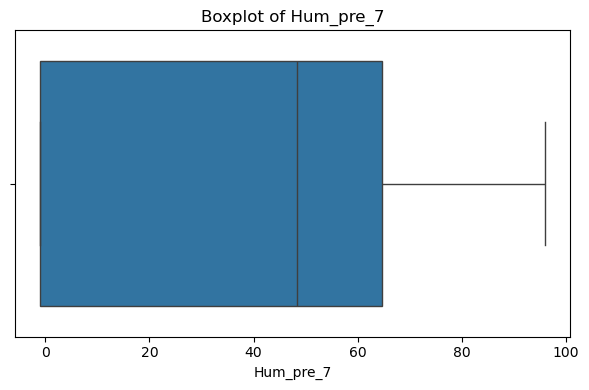

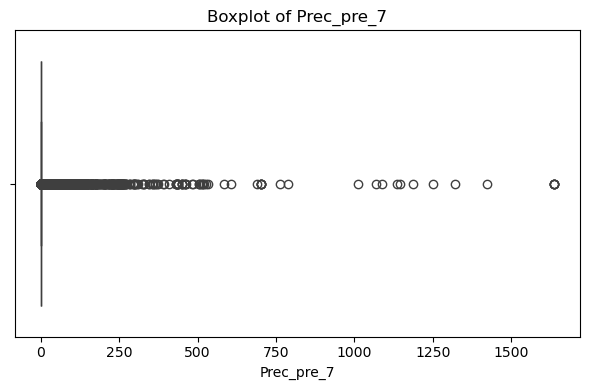

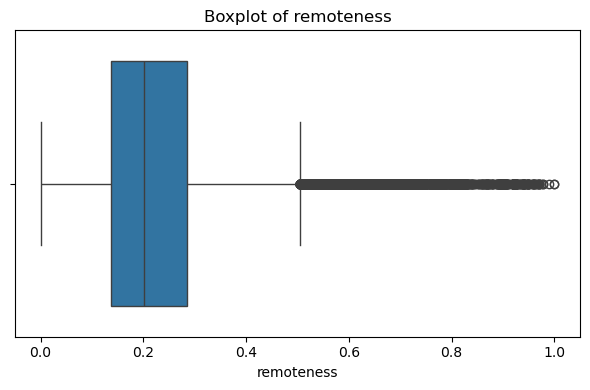

In [11]:
for col in num_cols_for_outliers:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()
    plt.show()


In [12]:
def detect_outliers_iqr(dataframe, columns):
    outliers_count = {}
    for col in columns:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mask = (dataframe[col] < lower) | (dataframe[col] > upper)
        outliers_count[col] = mask.sum()
    return outliers_count

outlier_counts = detect_outliers_iqr(df, num_cols_for_outliers)
print("Outlier counts per numeric column :")
for k, v in outlier_counts.items():
    print(f"{k}: {v}")


Outlier counts per numeric column :
disc_pre_year: 0
dstation_m: 1267
fire_mag: 8031
Temp_pre_7: 1
Wind_pre_7: 15
Hum_pre_7: 0
Prec_pre_7: 10084
remoteness: 3171


__Encoding__

Label Encoding Target 

In [13]:
label_enc = LabelEncoder()
df[target_col] = label_enc.fit_transform(df[target_col])

Frequency encoding

In [14]:
freq_maps = {}  # store to reuse later (e.g. for inference/Flask)

for col in freq_cols:
    freq = df[col].value_counts()        
    freq_map = freq.to_dict()            
    df[col + "_freq"] = df[col].map(freq_map)
    freq_maps[col] = freq_map   

In [15]:
encoded_freq_cols = [c + "_freq" for c in freq_cols]

Ordinal encoding

In [16]:
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

veg_order = [
    "Grassland",
    "Agricultural Land",
    "Shrubland",
    "Wetlands",
    "Deciduous Forest",
    "Mixed Forest",
    "Evergreen Forest"
]
ord_enc = OrdinalEncoder(categories=[month_order, veg_order],handle_unknown="use_encoded_value",unknown_value=-1)
df[ord_cols] = ord_enc.fit_transform(df[ord_cols])

In [17]:
df.columns

Index(['fire_size_class', 'stat_cause_descr', 'latitude', 'longitude', 'state',
       'disc_pre_year', 'disc_pre_month', 'wstation_usaf', 'dstation_m',
       'Vegetation', 'fire_mag', 'Temp_pre_7', 'Wind_pre_7', 'Hum_pre_7',
       'Prec_pre_7', 'remoteness', 'state_freq', 'stat_cause_descr_freq',
       'wstation_usaf_freq'],
      dtype='object')

In [18]:
df.head()

,fire_size_class,stat_cause_descr,latitude,longitude,state,disc_pre_year,disc_pre_month,wstation_usaf,dstation_m,Vegetation,fire_mag,Temp_pre_7,Wind_pre_7,Hum_pre_7,Prec_pre_7,remoteness,state_freq,stat_cause_descr_freq,wstation_usaf_freq
0,1,Missing/Undefined,18.105072,-66.753044,PR,2007,0.0,785140,58917.69716,2.0,1.0,24.902597,3.262092,76.381579,0.0,0.017923,747,5042,375
1,0,Arson,35.038330,-87.610000,TN,2006,10.0,723235,32665.34327,1.0,0.1,0.343529,1.976471,55.505882,0.0,0.184355,1190,9710,305
2,1,Arson,34.947800,-88.722500,MS,2004,0.0,723235,105122.14950,3.0,1.0,5.558750,2.695833,76.812834,18.1,0.194544,3493,9710,305
3,0,Debris Burning,39.641400,-119.308300,NV,2005,4.0,724880,43433.32978,6.0,0.1,18.142564,3.671282,35.353846,0.0,0.487447,658,14270,67
4,0,Miscellaneous,30.700600,-90.591400,LA,1999,7.0,722312,25940.57409,2.0,0.1,-1.000000,-1.000000,-1.000000,-1.0,0.214633,1292,8340,373


__Standardization for numeric columns__

In [22]:
scaler = StandardScaler()
df[num_cols_all] = scaler.fit_transform(df[num_cols_all])


In [23]:
X = df[encoded_freq_cols + ord_cols + num_cols_all]
y = df[target_col]

print("Final feature columns:")
print(X.columns.tolist())


Final feature columns:
['state_freq', 'stat_cause_descr_freq', 'wstation_usaf_freq', 'disc_pre_month', 'Vegetation', 'latitude', 'longitude', 'disc_pre_year', 'dstation_m', 'fire_mag', 'Temp_pre_7', 'Wind_pre_7', 'Hum_pre_7', 'Prec_pre_7', 'remoteness']


__Train-test split__

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

__Define models + hyperparameter grids__

In [25]:
models_and_params = {
    "RandomForest": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {
            "n_estimators": [100, 200],
            "max_depth": [None, 20, 40],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    ),
    "SVM": (
        SVC(random_state=42),
        {
            "C": [0.5, 1, 5],
            "gamma": ["scale", 0.01, 0.001],
            "kernel": ["rbf"]
        }
    ),
    "LogisticRegression": (
        LogisticRegression(
            max_iter=500,
            multi_class="multinomial",
            solver="lbfgs",
            n_jobs=-1,
            random_state=42
        ),
        {
            "C": [0.1, 1, 10]
        }
    ),
    "DecisionTree": (
        DecisionTreeClassifier(random_state=42),
        {
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    ),
    "GradientBoosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "n_estimators": [100, 200],
            "learning_rate": [0.05, 0.1],
            "max_depth": [3, 5],
            "subsample": [0.8, 1.0]
        }
    )
}

best_models = {}
scores = {}

In [26]:
baseline_models = {
    "RandomForest_base": RandomForestClassifier(random_state=42, n_jobs=-1),
    "SVM_base": SVC(random_state=42),
    "LogReg_base": LogisticRegression(
        max_iter=500,
        multi_class="multinomial",
        solver="lbfgs",
        n_jobs=-1,
        random_state=42
    ),
    "DecisionTree_base": DecisionTreeClassifier(random_state=42),
    "GradientBoosting_base": GradientBoostingClassifier(random_state=42)
}

baseline_scores = {}

for name, model in baseline_models.items():
    print(f"\nTraining baseline {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    baseline_scores[name] = acc
    print(f"{name} accuracy (before tuning): {acc:.4f}")
    print(classification_report(y_test, y_pred))


Training baseline RandomForest_base...
RandomForest_base accuracy (before tuning): 0.9987
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7296
           1       1.00      1.00      1.00      2160
           2       1.00      0.99      0.99       279
           3       0.93      0.99      0.96       140
           4       1.00      0.97      0.99       394
           5       1.00      1.00      1.00       794

    accuracy                           1.00     11063
   macro avg       0.99      0.99      0.99     11063
weighted avg       1.00      1.00      1.00     11063


Training baseline SVM_base...
SVM_base accuracy (before tuning): 0.6595
              precision    recall  f1-score   support

           0       0.66      1.00      0.79      7296
           1       0.00      0.00      0.00      2160
           2       0.00      0.00      0.00       279
           3       0.00      0.00      0.00       140
           4       0.0

C:\Users\chait\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chait\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chait\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chait\anaconda\Lib\site-packages\s

LogReg_base accuracy (before tuning): 0.6903
              precision    recall  f1-score   support

           0       0.69      0.99      0.81      7296
           1       0.24      0.02      0.04      2160
           2       0.00      0.00      0.00       279
           3       0.00      0.00      0.00       140
           4       0.00      0.00      0.00       394
           5       0.96      0.50      0.65       794

    accuracy                           0.69     11063
   macro avg       0.31      0.25      0.25     11063
weighted avg       0.57      0.69      0.59     11063


Training baseline DecisionTree_base...
DecisionTree_base accuracy (before tuning): 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7296
           1       1.00      1.00      1.00      2160
           2       1.00      1.00      1.00       279
           3       1.00      1.00      1.00       140
           4       1.00      1.00      1.00       

C:\Users\chait\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chait\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chait\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


GradientBoosting_base accuracy (before tuning): 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7296
           1       1.00      1.00      1.00      2160
           2       1.00      1.00      1.00       279
           3       1.00      1.00      1.00       140
           4       1.00      1.00      1.00       394
           5       1.00      1.00      1.00       794

    accuracy                           1.00     11063
   macro avg       1.00      1.00      1.00     11063
weighted avg       1.00      1.00      1.00     11063



__Hyperparameter tuning__

In [27]:
for name, (model, param_grid) in models_and_params.items():
    print(f"\nTuning {name}...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,
        scoring="f1_weighted",
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_models[name] = best_model

    print(f"Best params for {name}: {grid.best_params_}")
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    scores[name] = acc
    print(f"{name} accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))


Tuning RandomForest...
Best params for RandomForest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
RandomForest accuracy: 0.9987
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7296
           1       1.00      1.00      1.00      2160
           2       1.00      0.99      0.99       279
           3       0.95      0.98      0.96       140
           4       0.99      0.98      0.99       394
           5       1.00      1.00      1.00       794

    accuracy                           1.00     11063
   macro avg       0.99      0.99      0.99     11063
weighted avg       1.00      1.00      1.00     11063


Tuning SVM...
Best params for SVM: {'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}
SVM accuracy: 0.7191
              precision    recall  f1-score   support

           0       0.74      0.93      0.82      7296
           1       0.33      0.12      0.18      2160
           2       0.03 

C:\Users\chait\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best params for LogisticRegression: {'C': 0.1}
LogisticRegression accuracy: 0.7156
              precision    recall  f1-score   support

           0       0.72      0.98      0.83      7296
           1       0.22      0.02      0.04      2160
           2       0.00      0.00      0.00       279
           3       0.00      0.00      0.00       140
           4       0.00      0.00      0.00       394
           5       0.85      0.87      0.86       794

    accuracy                           0.72     11063
   macro avg       0.30      0.31      0.29     11063
weighted avg       0.58      0.72      0.62     11063


Tuning DecisionTree...


C:\Users\chait\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chait\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chait\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best params for DecisionTree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecisionTree accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7296
           1       1.00      1.00      1.00      2160
           2       1.00      1.00      1.00       279
           3       1.00      1.00      1.00       140
           4       1.00      1.00      1.00       394
           5       1.00      1.00      1.00       794

    accuracy                           1.00     11063
   macro avg       1.00      1.00      1.00     11063
weighted avg       1.00      1.00      1.00     11063


Tuning GradientBoosting...
Best params for GradientBoosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
GradientBoosting accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7296
           1       1.00      1.00      1.00   

__Pick best model__

In [28]:
best_model_name = max(scores, key=scores.get)
best_model = best_models[best_model_name]
print("Best model:", best_model_name, "with accuracy:", scores[best_model_name])


Best model: DecisionTree with accuracy: 1.0


__Save for Flask__

In [30]:
import pickle
import os

In [31]:
os.makedirs("model", exist_ok=True)

In [32]:
artifacts = {
    "model": best_model,
    "scaler": scaler,
    "ordinal_encoder": ord_enc,
    "label_encoder": label_enc,
    "freq_maps": freq_maps,
    "freq_cols": freq_cols,
    "ord_cols": ord_cols,
    "num_cols_all": num_cols_all
}

In [33]:
with open("model/fire_artifacts.pkl", "wb") as f:
    pickle.dump(artifacts, f)

print("Artifacts saved to model/fire_artifacts.pkl")

Artifacts saved to model/fire_artifacts.pkl
